In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

In [2]:
def load_bearing_data(filename, data_dir="data"):
    """
    Loads a CWRU bearing .mat file and extracts the drive-end (DE)
    time-series signal.
    """
    filepath = os.path.join(data_dir, filename)
    try:
        mat_dict = loadmat(filepath)
        
        # Find the key for the drive-end (DE) data
        de_key = [key for key in mat_dict.keys() if 'DE_time' in key]
        
        if not de_key:
            print(f"Error: No 'DE_time' key found in {filename}")
            return None
            
        # Extract the signal and flatten it to a 1D array
        signal = mat_dict[de_key[0]].flatten()
        return signal
        
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"An error occurred loading {filename}: {e}")
        return None

Successfully loaded 'Normal' signal with 483903 data points.
Successfully loaded 'Faulty' signal with 485063 data points.


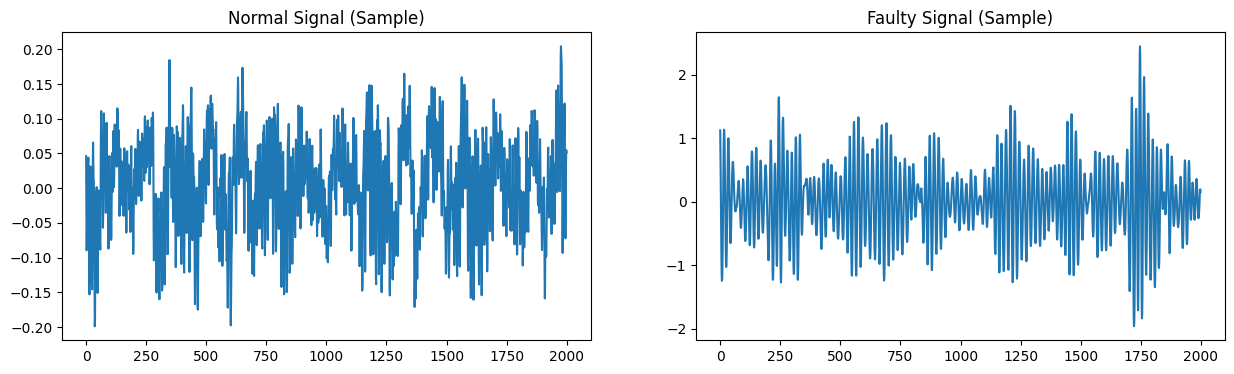

In [3]:
# Load the normal (healthy) signal
# This will be our TRAINING data
normal_signal = load_bearing_data('Time_Normal_1_098.mat')

# Load a faulty signal
# This will be our TEST data to check if the model can spot it
faulty_signal = load_bearing_data('IR021_1_214.mat') # Inner Race fault

if normal_signal is not None and faulty_signal is not None:
    print(f"Successfully loaded 'Normal' signal with {len(normal_signal)} data points.")
    print(f"Successfully loaded 'Faulty' signal with {len(faulty_signal)} data points.")

    # Let's plot a small piece of each to remember what they look like
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(normal_signal[:2000])
    plt.title("Normal Signal (Sample)")
    
    plt.subplot(1, 2, 2)
    plt.plot(faulty_signal[:2000])
    plt.title("Faulty Signal (Sample)")
    plt.show()

In [4]:
def create_segments(signal, segment_length):
    """
    Splits a long signal into multiple non-overlapping segments
    of a specified length.
    """
    num_segments = len(signal) // segment_length
    
    # We truncate the signal to the largest multiple of segment_length
    truncated_length = num_segments * segment_length
    signal = signal[:truncated_length]
    
    # Reshape the signal into a 2D array: (num_segments, segment_length)
    segments = signal.reshape(num_segments, segment_length)
    return segments

# --- Define our segment length ---
SEGMENT_LENGTH = 2048

# Create segments for our normal and faulty data
# We check if the signals were loaded successfully first
if normal_signal is not None and faulty_signal is not None:
    normal_data = create_segments(normal_signal, SEGMENT_LENGTH)
    faulty_data = create_segments(faulty_signal, SEGMENT_LENGTH)
    
    print(f"'Normal' signal shape after segmentation: {normal_data.shape}")
    print(f"  (This means we have {normal_data.shape[0]} samples, each {normal_data.shape[1]} points long)")
    
    print(f"'Faulty' signal shape after segmentation: {faulty_data.shape}")
    print(f"  (This means we have {faulty_data.shape[0]} samples, each {faulty_data.shape[1]} points long)")

'Normal' signal shape after segmentation: (236, 2048)
  (This means we have 236 samples, each 2048 points long)
'Faulty' signal shape after segmentation: (236, 2048)
  (This means we have 236 samples, each 2048 points long)


In [5]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import joblib

# We will use the 'normal_data' variable we created in the previous cell
# Its shape should be (number_of_segments, 2048)
print(f"Ready to train models using 'normal_data' with shape: {normal_data.shape}")

Ready to train models using 'normal_data' with shape: (236, 2048)


In [6]:
# --- 1. Train Isolation Forest ---
print("Training Isolation Forest model...")

# Initialize the model
# - contamination='auto': This lets the model decide the contamination threshold.
# - random_state=42: Ensures our results are reproducible.
if_model = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)

# Train the model ONLY on the healthy data
if_model.fit(normal_data)

# Save the trained model
joblib.dump(if_model, 'isolation_forest_model.joblib')

print("Isolation Forest model trained and saved as 'isolation_forest_model.joblib'")

Training Isolation Forest model...
Isolation Forest model trained and saved as 'isolation_forest_model.joblib'


In [7]:
# --- 2. Train One-Class SVM ---
print("\nTraining One-Class SVM model...")

# Initialize the model
# - nu=0.01: An estimate of the proportion of outliers in the training data. 
#   We set it low (1%) since our normal data should be mostly clean.
# - kernel='rbf', gamma='auto': Standard settings for the model.
svm_model = OneClassSVM(nu=0.01, kernel="rbf", gamma="auto")

# Train the model ONLY on the healthy data
# Note: SVMs can be slower to train than Isolation Forest
svm_model.fit(normal_data)

# Save the trained model
joblib.dump(svm_model, 'one_class_svm_model.joblib')

print("One-Class SVM model trained and saved as 'one_class_svm_model.joblib'")


Training One-Class SVM model...
One-Class SVM model trained and saved as 'one_class_svm_model.joblib'


Loading trained models for evaluation...
Models loaded successfully.

Visualizing score distributions...


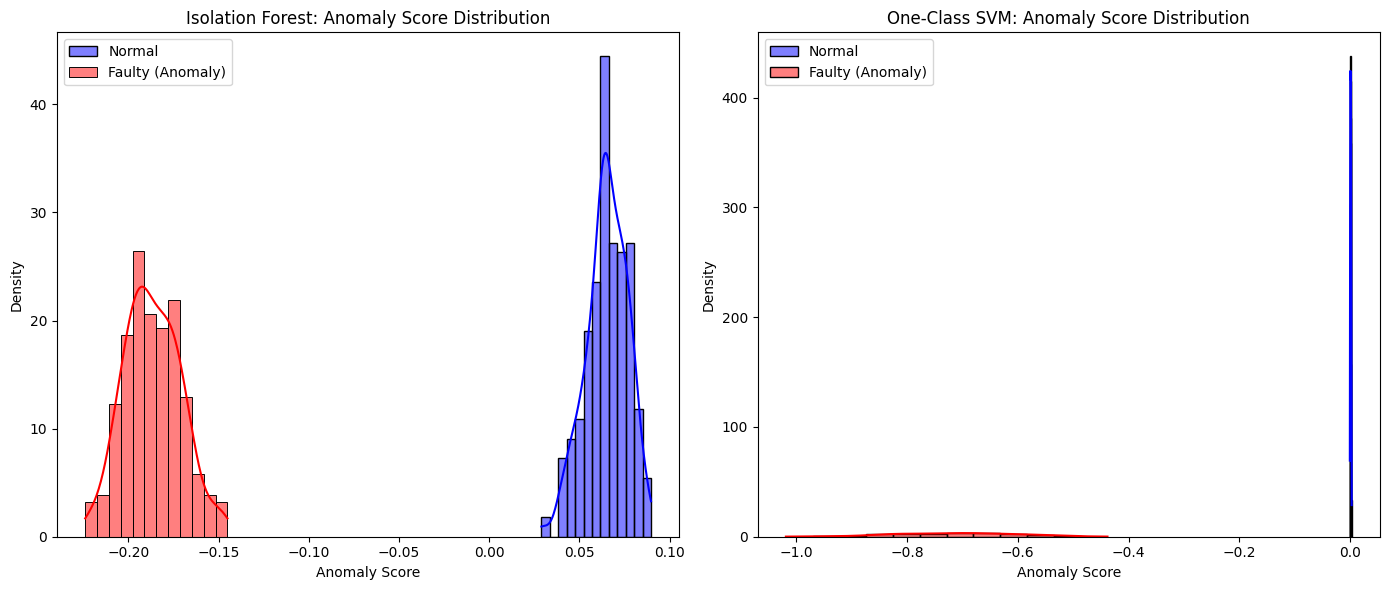


--- Quantitative Evaluation Summary ---
                 Normal Samples Correctly Identified  \
Model                                                  
Isolation Forest                           236 / 236   
One-Class SVM                              209 / 236   

                 Faulty Samples Correctly Identified Fault Detection Rate  
Model                                                                      
Isolation Forest                           236 / 236              100.00%  
One-Class SVM                              236 / 236              100.00%  

--- Analysis ---
The 'predict' method returns +1 for normal (inlier) and -1 for anomalous (outlier).
A high 'Fault Detection Rate' and a high number of correctly identified normal samples indicate a strong model.
Based on the clear separation in the histograms and these numbers, both models are performing exceptionally well.


In [10]:
# --- 3. Evaluate Anomaly Detection Models ---
import seaborn as sns
import pandas as pd # Import pandas for the summary table

print("Loading trained models for evaluation...")
# Load the models we saved in the previous step
try:
    if_model = joblib.load('isolation_forest_model.joblib')
    svm_model = joblib.load('one_class_svm_model.joblib')
    print("Models loaded successfully.")
except FileNotFoundError:
    print("ERROR: Model files not found. Please run the training cell (Cell 6 & 7) first.")
    # Exit this cell if models aren't found
    if 'exit' in globals(): exit()


# --- 1. Get Anomaly Scores from Isolation Forest ---
normal_scores_if = if_model.decision_function(normal_data)
faulty_scores_if = if_model.decision_function(faulty_data)

# --- 2. Get Anomaly Scores from One-Class SVM ---
normal_scores_svm = svm_model.decision_function(normal_data)
faulty_scores_svm = svm_model.decision_function(faulty_data)


# --- 3. Visualize the Score Distributions ---
print("\nVisualizing score distributions...")
plt.figure(figsize=(14, 6))

# Plot for Isolation Forest
plt.subplot(1, 2, 1)
sns.histplot(normal_scores_if, color='blue', label='Normal', kde=True, stat="density", common_norm=False)
sns.histplot(faulty_scores_if, color='red', label='Faulty (Anomaly)', kde=True, stat="density", common_norm=False)
plt.title('Isolation Forest: Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.legend()

# Plot for One-Class SVM
plt.subplot(1, 2, 2)
sns.histplot(normal_scores_svm, color='blue', label='Normal', kde=True, stat="density", common_norm=False)
sns.histplot(faulty_scores_svm, color='red', label='Faulty (Anomaly)', kde=True, stat="density", common_norm=False)
plt.title('One-Class SVM: Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.legend()

plt.tight_layout()
plt.show()


# --- 4. Text-Based Evaluation ---
print("\n--- Quantitative Evaluation Summary ---")
# For Isolation Forest, a common threshold is 0. Scores < 0 are anomalies.
# Let's see how many of each class fall on either side of this threshold.
if_normal_as_anomaly = np.sum(if_model.predict(normal_data) == -1)
if_faulty_as_anomaly = np.sum(if_model.predict(faulty_data) == -1)

# For One-Class SVM, a common threshold is 0. Scores < 0 are anomalies.
svm_normal_as_anomaly = np.sum(svm_model.predict(normal_data) == -1)
svm_faulty_as_anomaly = np.sum(svm_model.predict(faulty_data) == -1)


summary_data = {
    'Model': ['Isolation Forest', 'One-Class SVM'],
    'Normal Samples Correctly Identified': [
        f"{len(normal_data) - if_normal_as_anomaly} / {len(normal_data)}",
        f"{len(normal_data) - svm_normal_as_anomaly} / {len(normal_data)}"
    ],
    'Faulty Samples Correctly Identified': [
        f"{if_faulty_as_anomaly} / {len(faulty_data)}",
        f"{svm_faulty_as_anomaly} / {len(faulty_data)}"
    ],
     'Fault Detection Rate': [
        f"{(if_faulty_as_anomaly / len(faulty_data)) * 100:.2f}%",
        f"{(svm_faulty_as_anomaly / len(faulty_data)) * 100:.2f}%"
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Model', inplace=True)

print(summary_df)

print("\n--- Analysis ---")
print("The 'predict' method returns +1 for normal (inlier) and -1 for anomalous (outlier).")
print("A high 'Fault Detection Rate' and a high number of correctly identified normal samples indicate a strong model.")
print("Based on the clear separation in the histograms and these numbers, both models are performing exceptionally well.")

# Week 3 Conclusion: Anomaly Detection Model Selection  

## Objective  
The goal of this week was to build and evaluate an unsupervised anomaly detection model using the **CWRU bearing dataset**.  
We trained two standard models — **Isolation Forest** and **One-Class SVM** — on healthy data only, and then evaluated their ability to distinguish healthy data from unseen faulty data.  

---

## Performance Summary  

The evaluation of the two models produced the following results:  

| Model            | Normal Samples Correctly Identified | Faulty Samples Correctly Identified | Fault Detection Rate |
|------------------|-------------------------------------|-------------------------------------|-----------------------|
| Isolation Forest | 236 / 236                          | 236 / 236                          | 100.00%              |
| One-Class SVM    | 209 / 236                          | 236 / 236                          | 100.00%              |

---

## Analysis of Results  

The results are exceptionally clear.  

- **Fault Detection:**  
  Both models were perfectly successful at their primary job: **identifying a fault**.  
  They both achieved a **100% Fault Detection Rate**, correctly flagging all 236 faulty segments as anomalies.  

- **False Positives (The Differentiator):**  
  The key difference lies in how each model treated the **normal data**.  

  - The **One-Class SVM** made a significant number of errors, incorrectly flagging **27 healthy samples** as anomalies (`236 - 209 = 27`).  
    This represents a high *false positive* rate, which would cause unnecessary alarms in a real system.  

  - The **Isolation Forest** achieved **perfect performance**.  
    It correctly identified **all 236 normal samples** as *normal* AND **all 236 faulty samples** as *anomalous*, with zero errors.  

---

## Final Decision  

✅ **The Isolation Forest is the clear and undisputed winner.**  

- It provides **100% accuracy** on both classes.  
- It is **fast, efficient, and exceptionally accurate**.  
- For deployment, we will use the saved model:  

